In [1]:
import os
import glob
import pandas as pd
import csv
from io import StringIO
import io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm
import sys
scriptpath = r'....\\Springboard\\capstone1'
sys.path.insert(1, scriptpath)
import FunctionsKick as fkick
from sklearn.impute import KNNImputer

In [2]:
#!pip install fancyimpute

# 1.Read Data

In [3]:
#read data
kick_data = pd.read_csv('kickstarter\ks-projects-201801.csv')

In [4]:
#remove space in column names
kick_data.columns = kick_data.columns.str.strip()

In [5]:
kick_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 4:43,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 0:20,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 3:24,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 8:35,1283.0,canceled,14,US,1283.0,1283.0,19500.00


# 2. Data Cleaning

In [6]:
#convert to datetime 
kick_data.deadline = pd.to_datetime(kick_data.deadline)
kick_data.launched = pd.to_datetime(kick_data.launched)

In [7]:
#difference between when it was launched and the dealine
kick_data['launch_deadline_diff'] = kick_data.deadline - kick_data.launched

In [8]:
#get the month when it was launched and the deadline
kick_data['launched_month'] = kick_data.launched.dt.month
kick_data['deadline_month'] = kick_data.deadline.dt.month
#get the difference between launch month and deadline 


In [9]:
#get the mumber of days between launch and deadline
kick_data['launched_deadline_days_diff'] = kick_data['launch_deadline_diff'].astype(str).replace('\sdays.*','',
               
                                                                                                 regex = True).astype(int)

In [10]:
#get the difference between what was pledged and the goal
kick_data['pledged_goal_diff'] = kick_data['usd_pledged_real'] - kick_data['usd_goal_real']

In [11]:
#get outcome for goal
kick_data['goal_outcome'] =kick_data['pledged_goal_diff'].apply(lambda x: fkick.goal_launch(x))

## 2.1 Imputation

### 2.1.1 Encoding

In [12]:
kick_data = kick_data.replace('N,0"',np.nan)

In [13]:
kick_data2 = kick_data.drop(['name','launch_deadline_diff','currency','deadline','launched'], axis = 1)

In [14]:

cat_cols = ['category','main_category','state','goal_outcome','country']

In [15]:
encoded = pd.DataFrame({col: kick_data2[col].astype('category').cat.codes for col in kick_data2}, index=kick_data2.index)

In [16]:
#create data dictionary of labels and encodings
data_dict = {col: {n: cat for n, cat in enumerate(kick_data[cat_cols][col].astype('category').cat.categories)} 
     for col in kick_data[cat_cols]}

### 2.1.2 KNN Imputation

In [17]:
imputer = KNNImputer(n_neighbors=5,missing_values = -1)
encode_data = pd.DataFrame(np.round(imputer.fit_transform(encoded)),columns = kick_data2.columns)


In [18]:
#for every column map encoding to a category
for col in cat_cols:
    encode_data[col] = encode_data[col].map(data_dict[col])

In [21]:
kick_data = pd.concat([encode_data, kick_data[['name','launch_deadline_diff','currency','deadline','launched']]],axis = 1)

In [22]:
kick_data.to_csv('kick_data_cleaned.csv')

# 3.StoryTelling

## 3.1 Overall

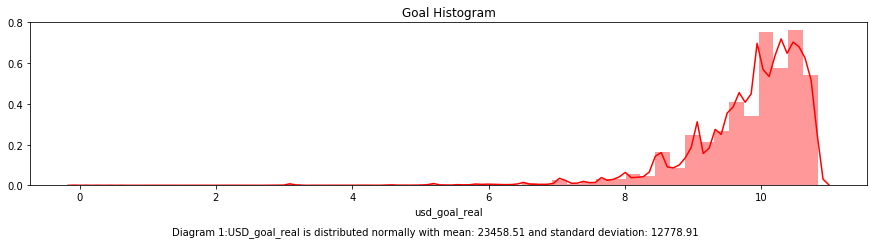

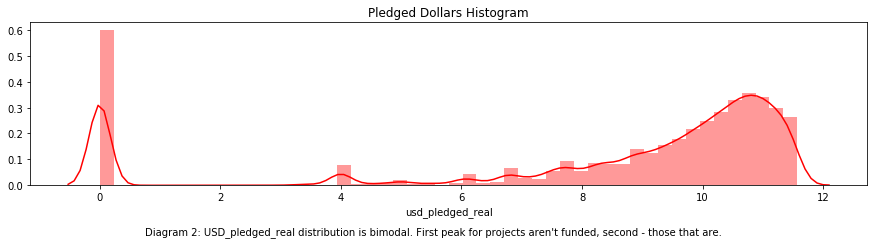

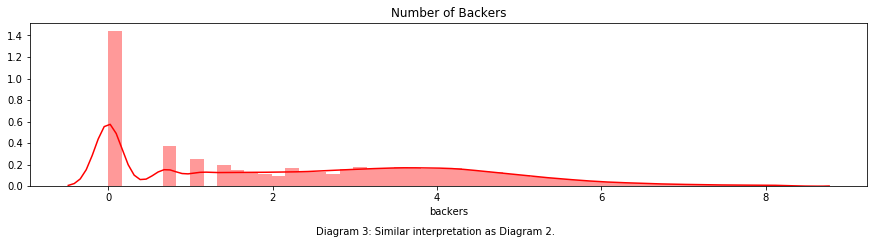

In [25]:

fig1 = plt.figure(figsize = (15,3))
#get mean
mean = kick_data['usd_goal_real'].mean()
#get std
std = kick_data['usd_goal_real'].std()
sns.distplot(kick_data['usd_goal_real'].apply(lambda x: fkick.log2(x)),color = 'r')
plt.title('Goal Histogram',loc = 'center')
#text
txt1 = """Diagram 1:USD_goal_real is distributed normally with mean: {:.2f} and standard deviation: {:.2f}""".format(mean,std)
fig1.text(.5, -0.1, txt1, ha='center')


fig2 = plt.figure(figsize = (15,3)) 
#histogram
sns.distplot(kick_data['usd_pledged_real'].apply(lambda x: fkick.log2(x)),color = 'r')
#title
plt.title('Pledged Dollars Histogram',loc = 'center')
#add text after graph
txt2 = "Diagram 2: USD_pledged_real distribution is bimodal. First peak for projects aren't funded, second - those that are. "
fig2.text(.5, -0.1, txt2, ha='center')

fig3 = plt.figure(figsize = (15,3))
#text
txt3 = """Diagram 3: Similar interpretation as Diagram 2."""
#histogram
sns.distplot(kick_data['backers'].apply(lambda x: fkick.log2(x)),color ='r')
#histogram
plt.title('Number of Backers',loc ='center')
fig3.text(.5, -0.1, txt3, ha='center')

plt.show()


## 3.2_Main_Categories

## 3.2.1

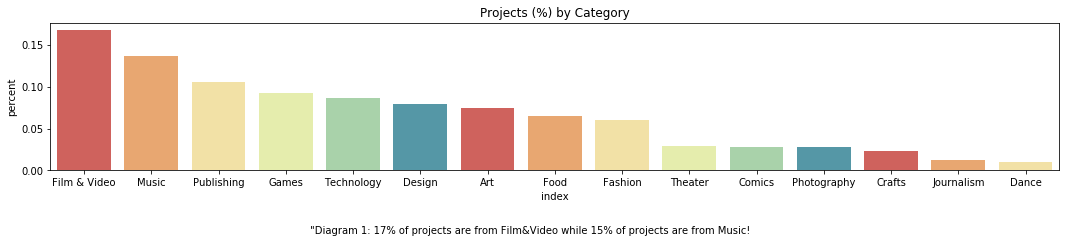

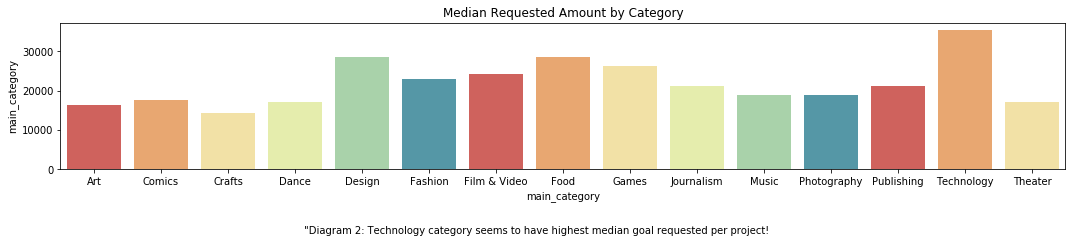

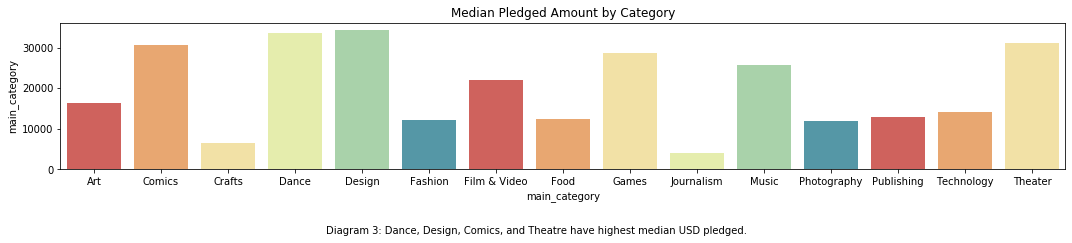

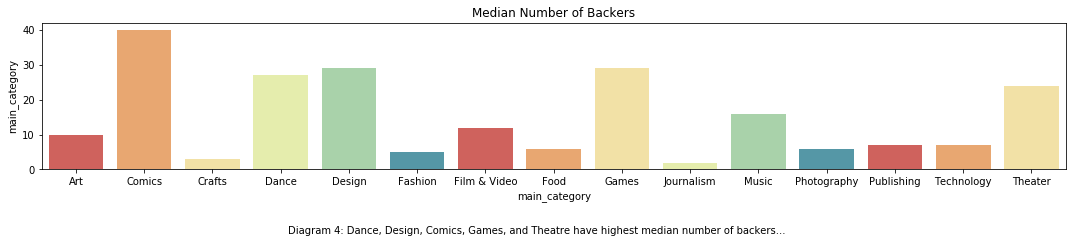

In [28]:
#chart 1
data1 = data=kick_data.main_category.value_counts(normalize = True).reset_index()
txt1 = """"Diagram 1: 17% of projects are from Film&Video while 15% of projects are from Music!"""

ax = fkick.barplot((15,3),'index','main_category',data1, txt1,'Projects (%) by Category')
ax.set(ylabel = 'percent')

#chart 2:

data2 = kick_data.groupby(['main_category']).agg({'usd_goal_real': 'median'}).reset_index()
txt2 = """"Diagram 2: Technology category seems to have highest median goal requested per project!"""

ax3 = fkick.barplot((15,3),'main_category','usd_goal_real',data2, txt2,'Median Requested Amount by Category')

#chart 3:
data3 = kick_data.groupby(['main_category']).agg({'usd_pledged_real': 'median'}).reset_index()
txt3 = """Diagram 3: Dance, Design, Comics, and Theatre have highest median USD pledged."""

ax3 = fkick.barplot((15,3),'main_category','usd_pledged_real',data3, txt3,'Median Pledged Amount by Category')

#chart 4:
data4 = kick_data.groupby(['main_category']).agg({'backers': 'median'}).reset_index() #data
txt4 = """Diagram 4: Dance, Design, Comics, Games, and Theatre have highest median number of backers..."""

ax4 = fkick.barplot((15,3),'main_category','backers',data4, txt4,'Median Number of Backers')

__Observation #1__: Based on this it seems that although there are high number of projects in Film & Video and Music Video.
         On average, Technology category tends to ask for more money than average; but doesn't translate to high number of 
         pledges. Instead, Theatre, Dance and Design categories are more likely to have higher number of people pledging
         and higher number of median pledge.

## 3.2.2


The distribution  is normal across different categories.


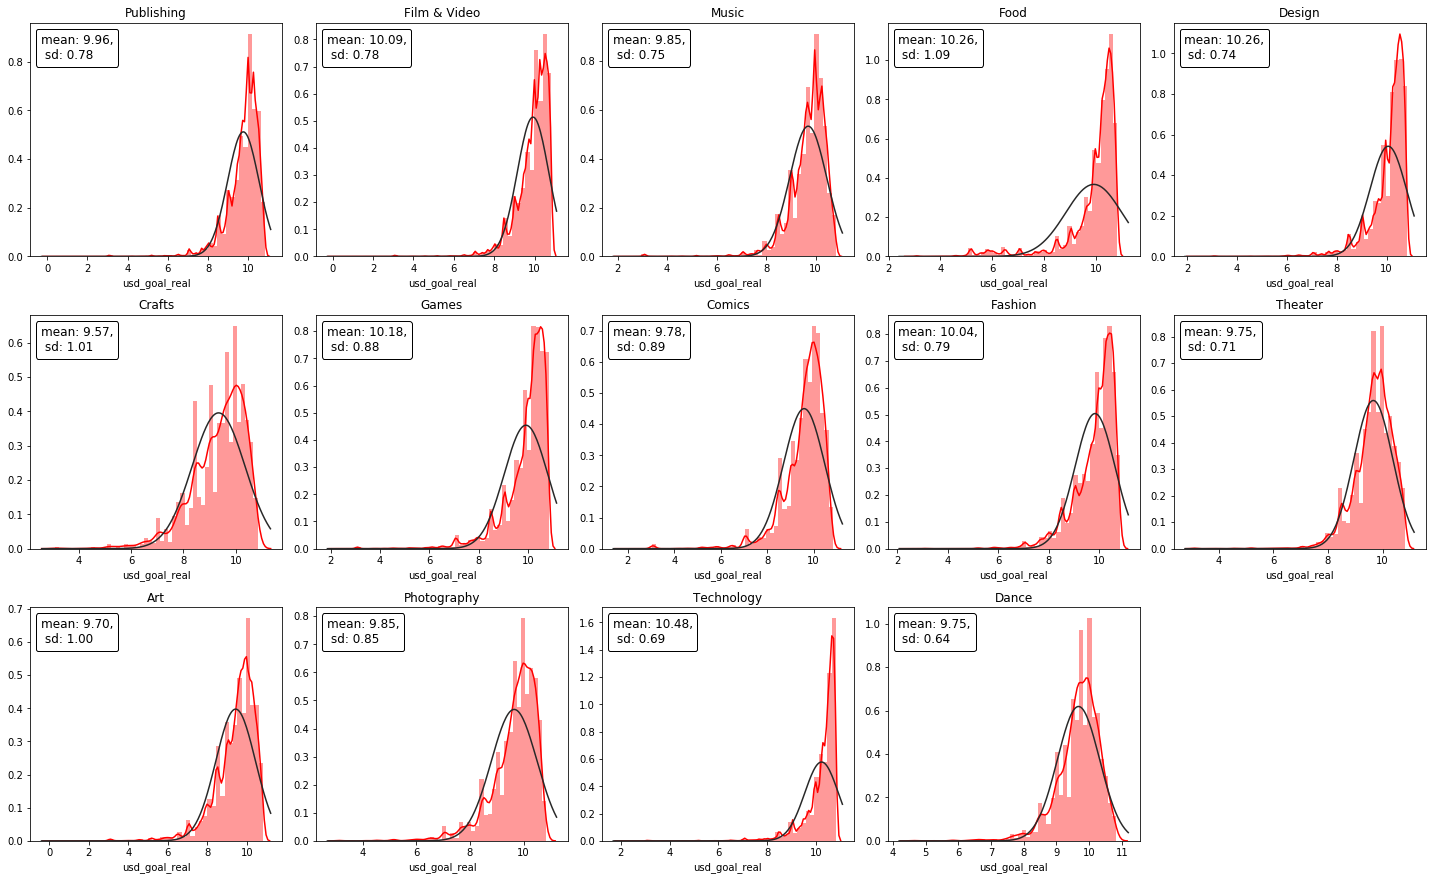

In [29]:
main_cat = kick_data.main_category.unique().tolist()
#look at  create_norm_subplot_log function defined at the begining
fkick.create_norm_subplot_log(kick_data,main_cat,'main_category',(20,20),'usd_goal_real',norm)
print("""
The distribution  is normal across different categories.""")

__Observation #2__: The highest mean is for Technology and Food and Design while lowest is for Crafts and Art. Highest standard deviation is for Food and lowest is for Music.This indicates that for Technology, Food, and Design people are more likely to request higher amount for their projects while the opposite is true for Crafts and Art. 

__Question__: Is there difference between the mean and standard deviation between different categories?

## 3.2.3

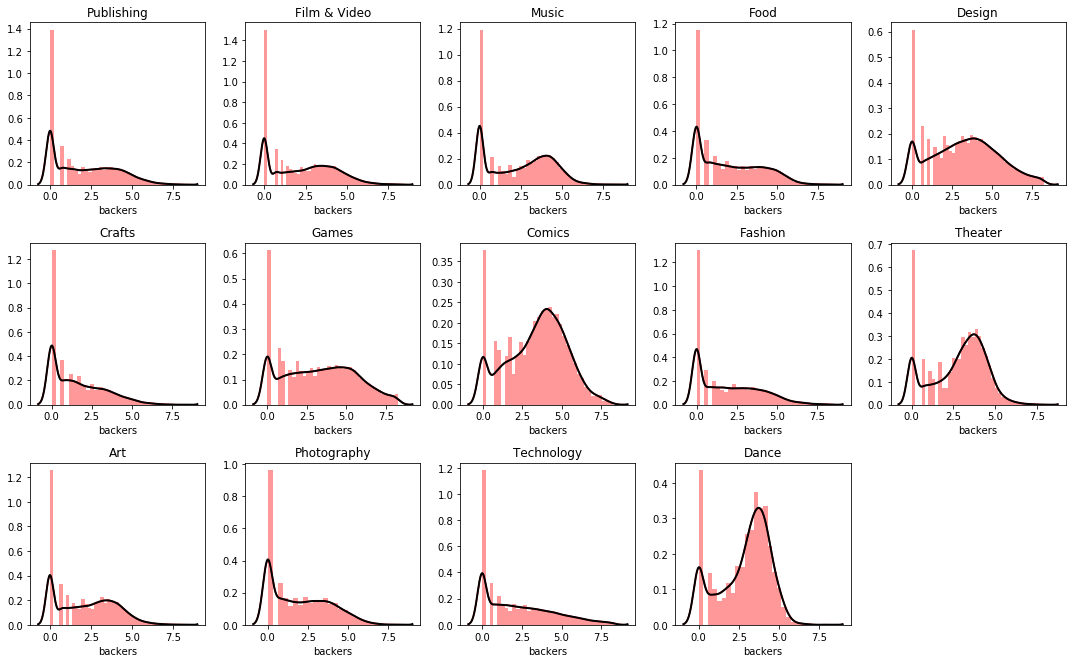

In [30]:

main_cat = kick_data.main_category.unique().tolist()
fkick.create_norm_subplot_log(kick_data,main_cat,'main_category',(15,15),'backers','kde')

__Observation #3:__ If you look at the bimodal distribution for Techology, and Publishing,it is more likely to have 0 people pledging than more than 1 pledging. Indicating that although Technology, for example, tend to ask for more money, very few of those projects actually have people interested in fundind them.

## 3.2.4

C:\Users\daniela.kutleva\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


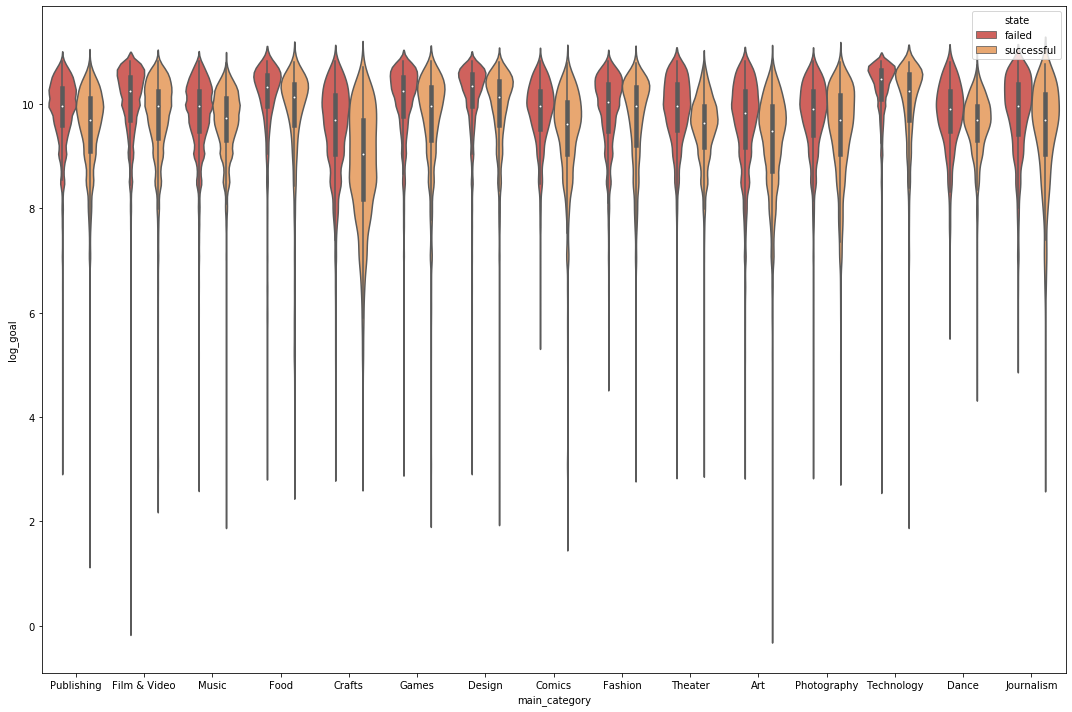

In [31]:
plt.figure(figsize = (15,10))
#get category, goal, and state
kick_data_log = kick_data[['main_category','usd_goal_real','state']]
#apply log to the data
kick_data_log['log_goal'] = kick_data_log['usd_goal_real'].apply(fkick.log2)
#plot but only where state is successful or failed
sns.violinplot(x= 'main_category', y= 'log_goal',scale="width", hue = "state",
               data=kick_data_log.query("state == 'successful' or state == 'failed'"),palette =sns.color_palette("Spectral"))
plt.tight_layout()

__Observation #4__: Based on the violin plot above, it seems that projects that fail tend to have higher distribution of values or at least some people tend to overestimate how much they can ask for particular project. Based on this, it seems, Comics successful projects tend to have lower mean amount requested compared to failed projects. On top of that, successful art projects tend to very wide range of possible values - in fact,they tend to have lowest min starting value compared to other projects.

# 3.3 Countries

## 3.3.1

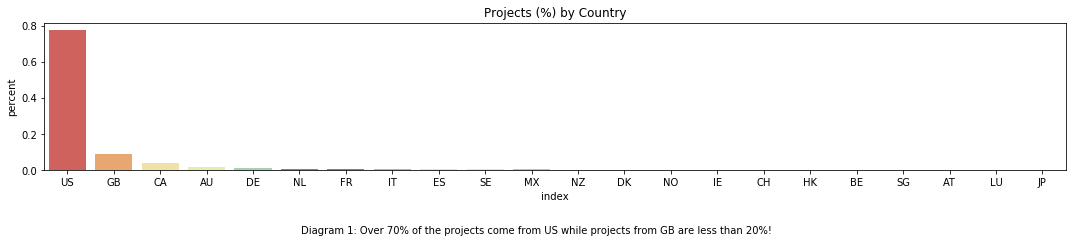

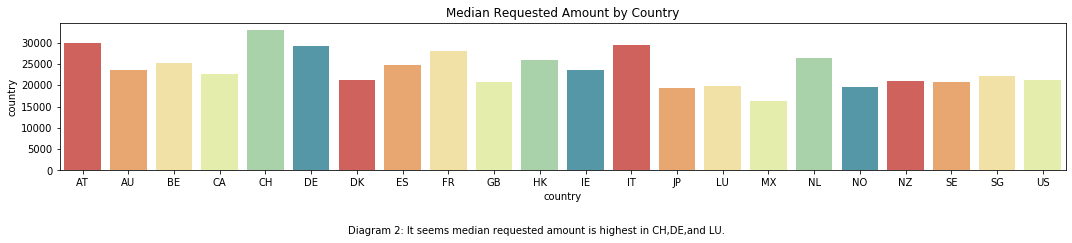

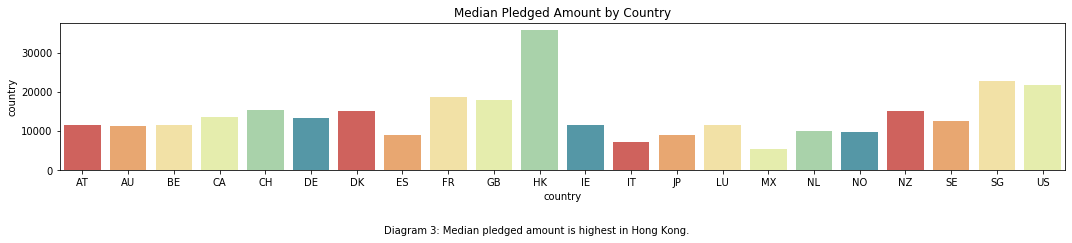

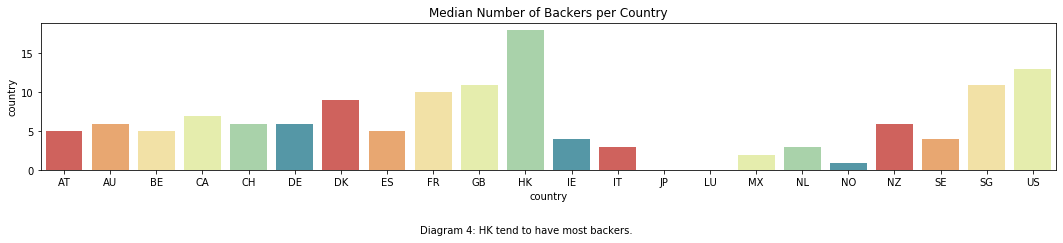

In [34]:
#chart 1
data1 = data=kick_data.country.value_counts(normalize = True).reset_index()
txt1 = """Diagram 1: Over 70% of the projects come from US while projects from GB are less than 20%!"""

ax = fkick.barplot((15,3),'index','country',data1, txt1,'Projects (%) by Country')
ax.set(ylabel = 'percent')

#chart 2:

data2 = kick_data.groupby(['country']).agg({'usd_goal_real': 'median'}).reset_index()
txt2 = """Diagram 2: It seems median requested amount is highest in CH,DE,and LU."""

ax3 = fkick.barplot((15,3),'country','usd_goal_real',data2, txt2,'Median Requested Amount by Country')

#chart 3:
data3 = kick_data.groupby(['country']).agg({'usd_pledged_real': 'median'}).reset_index()
txt3 = """Diagram 3: Median pledged amount is highest in Hong Kong."""

ax3 = fkick.barplot((15,3),'country','usd_pledged_real',data3, txt3,'Median Pledged Amount by Country')

#chart 4:
data4 = kick_data.groupby(['country']).agg({'backers': 'median'}).reset_index() #data
txt4 = """Diagram 4: HK tend to have most backers."""

ax4 = fkick.barplot((15,3),'country','backers',data4, txt4,'Median Number of Backers per Country')


__Observation #5__: While most of the projects are requested from the US; it seems that the median requested amount is highest in China compared to other countries. Furthermore, median number of backers and median pledged amount are highest in HK.

## 3.3.2

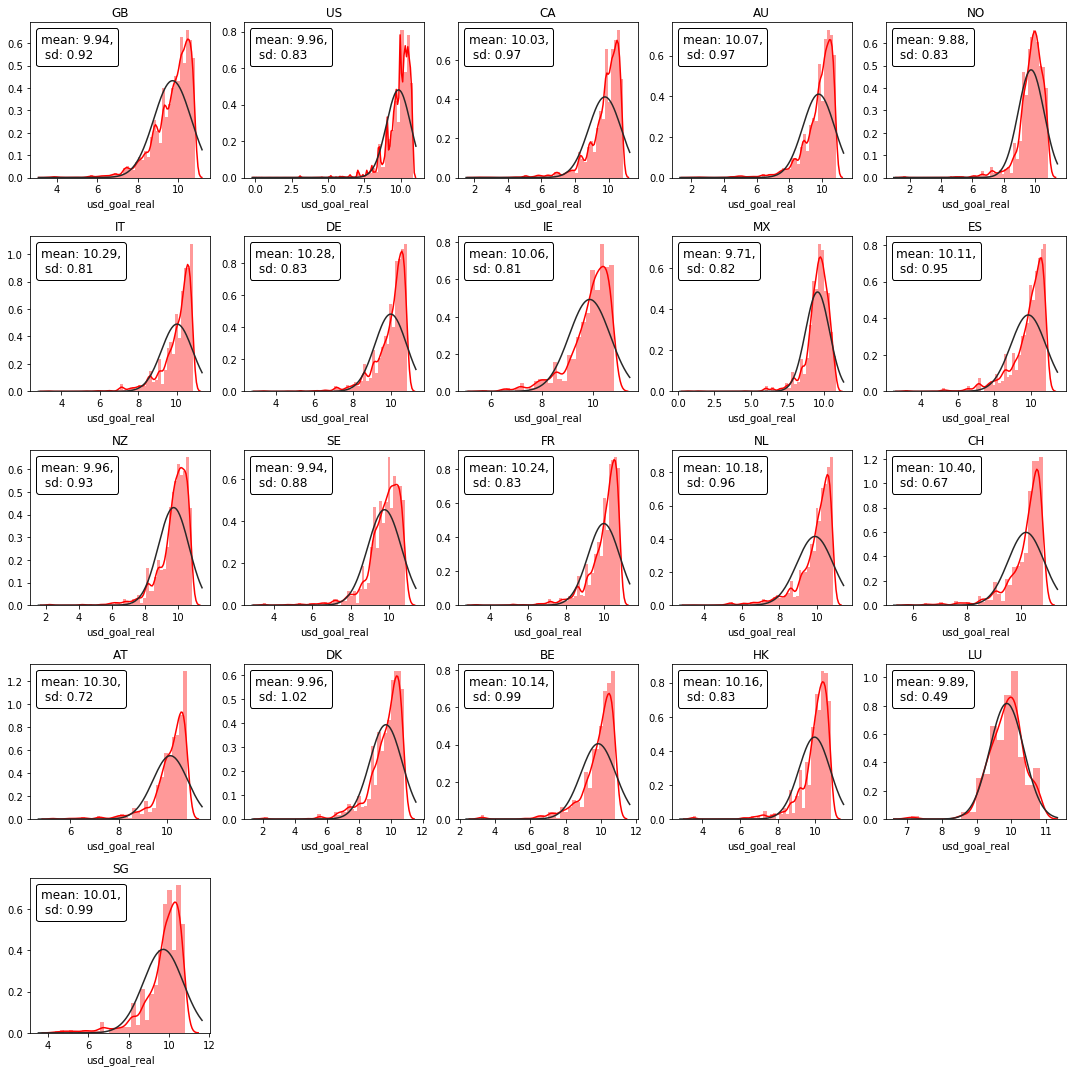

In [35]:
main_co = kick_data.country.unique().tolist()
fkick.create_norm_subplot_log(kick_data,main_co,'country',(15,15),'usd_goal_real',norm)


__Observation #6__: Highest means are are coming from CH, AT, DE, and LU while lowest means are from MX indicating that projects from CH,AT, DE, LU tend to ask higher amount of money compared to MX. NL and BE tend to have highest variance while MX showest lowest variance indicating that observations are clustered together.

## 3.3.3

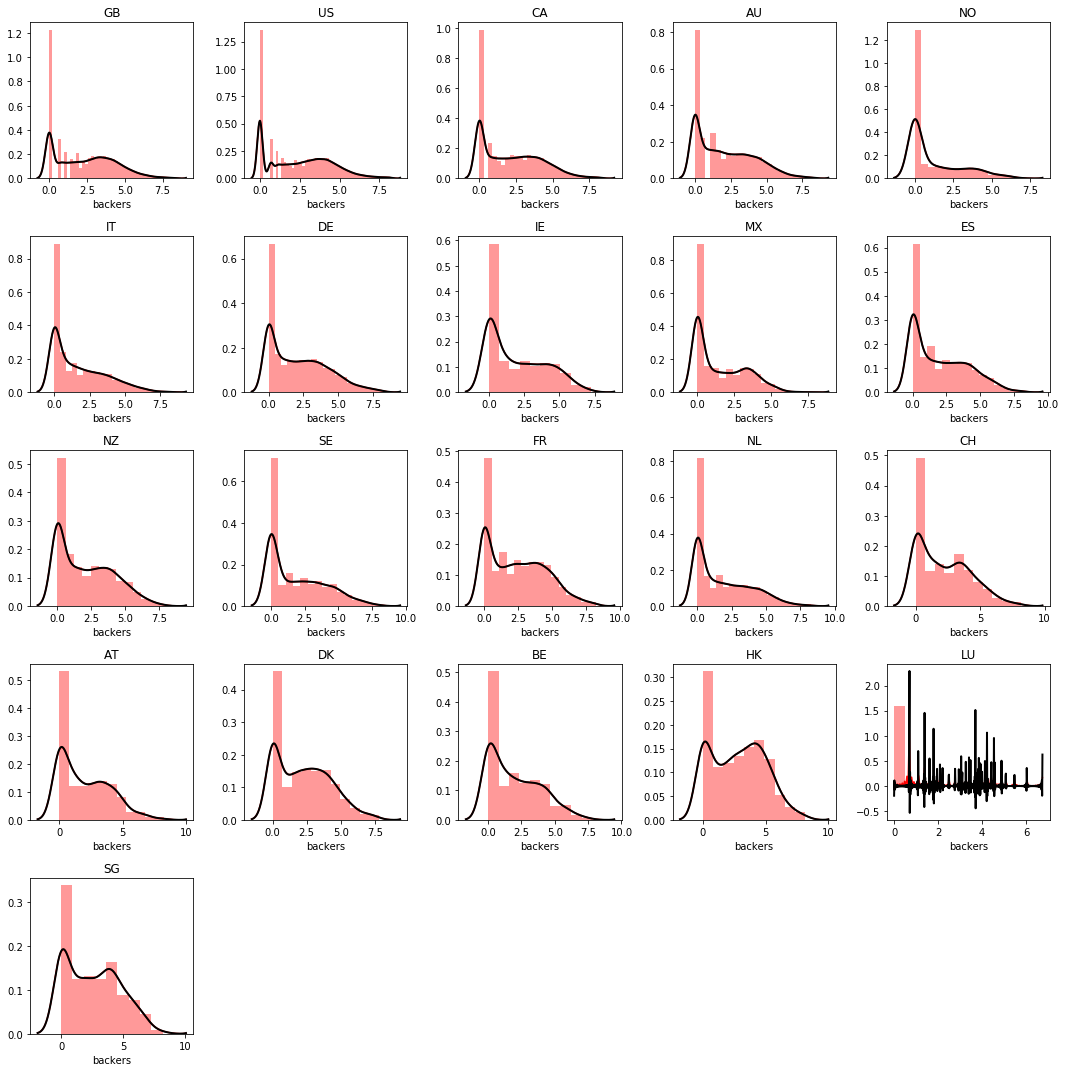

In [36]:
main_co = kick_data.country.unique().tolist()
fkick.create_norm_subplot_log(kick_data,main_co,'country',(15,15),'backers','kde')

__Observation #7__: Based on these graphs, it indicates US, BG, CA tend to have substantial number of projects with no pledges (around > 40%). There might not be enough data in LU.

## 3.3.4

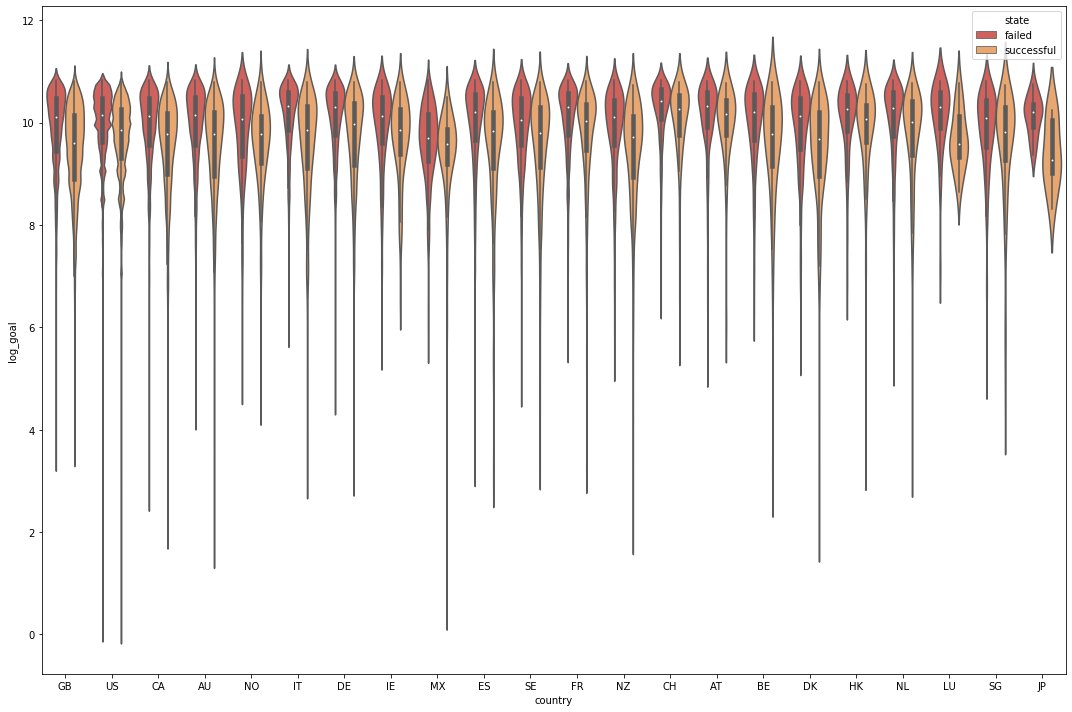

In [37]:
plt.figure(figsize = (15,10))
#select country, usd_goal_real, state where state is successful or failed
kick_data_log = kick_data[['country','usd_goal_real','state']].query("state == 'successful' or state == 'failed'")
#apply log to usd_goal_real
kick_data_log['log_goal'] = kick_data_log['usd_goal_real'].apply(fkick.log2)

#violinplot
sns.violinplot(x= 'country', y= 'log_goal',scale="width", hue = "state",
               data=kick_data_log,palette =sns.color_palette("Spectral"))
plt.tight_layout()

__Observation #8__: Distribution for failed project is in generally much larger indicating people overestimate how much people are willing to fund them. Furthermore, we see in JP, the distribution is much lower for both failed and successful projects compared to other countries indicating perhaps that there are few people that overestimate willingness of people to fund. 

# 3.4 State

## 3.4.1

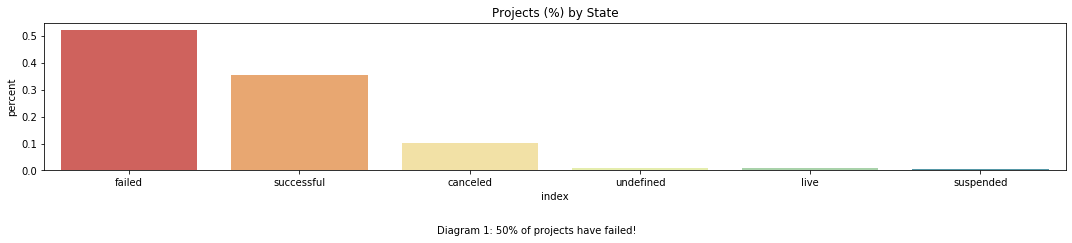

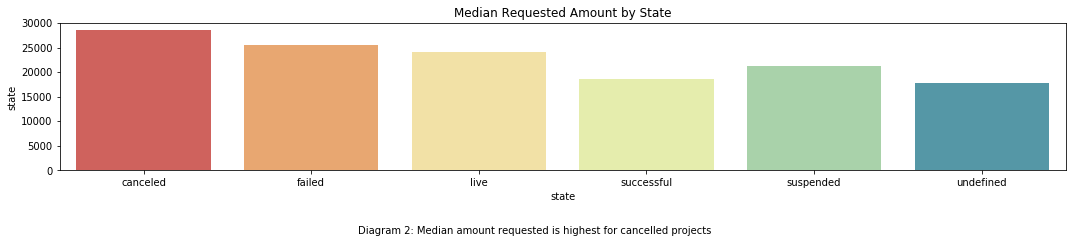

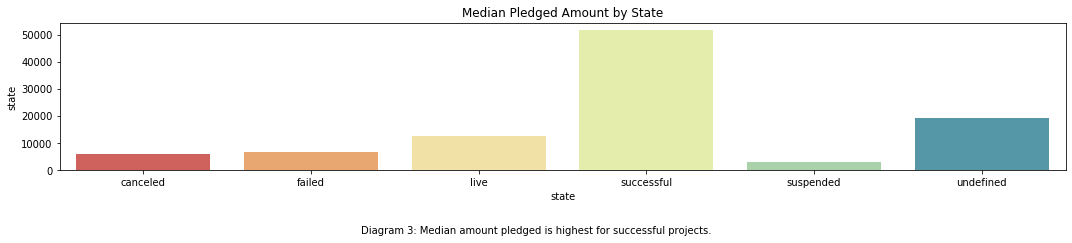

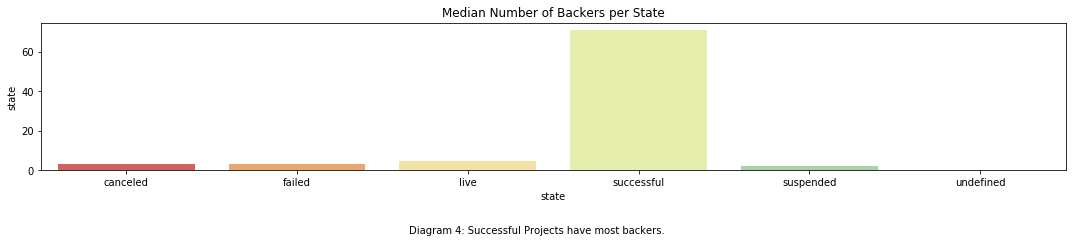

In [40]:
#chart 1
data1 = kick_data.state.value_counts(normalize = True).reset_index()
txt1 = """Diagram 1: 50% of projects have failed!"""

ax = fkick.barplot((15,3),'index','state',data1, txt1,'Projects (%) by State')
ax.set(ylabel = 'percent')

#chart 2:

data2 = kick_data.groupby(['state']).agg({'usd_goal_real': 'median'}).reset_index()
txt2 = """Diagram 2: Median amount requested is highest for cancelled projects """

ax3 = fkick.barplot((15,3),'state','usd_goal_real',data2, txt2,'Median Requested Amount by State')

#chart 3:
data3 = kick_data.groupby(['state']).agg({'usd_pledged_real': 'median'}).reset_index()
txt3 = """Diagram 3: Median amount pledged is highest for successful projects."""

ax3 = fkick.barplot((15,3),'state','usd_pledged_real',data3, txt3,'Median Pledged Amount by State')

#chart 4:
data4 = kick_data.groupby(['state']).agg({'backers': 'median'}).reset_index() #data
txt4 = """Diagram 4: Successful Projects have most backers."""

ax4 = fkick.barplot((15,3),'state','backers',data4, txt4,'Median Number of Backers per State')

__Observation #9__: You can see most of the successful projects tend have most pledges and most money towards. However, in total, it seems like most projects (around 50%) tend to fail. In contrast, projects that are cancelled tend to have highest mean goal amount. This indicates that those that request high amount then to cancel it when they realize they have asked for too much.

## 3.4.2

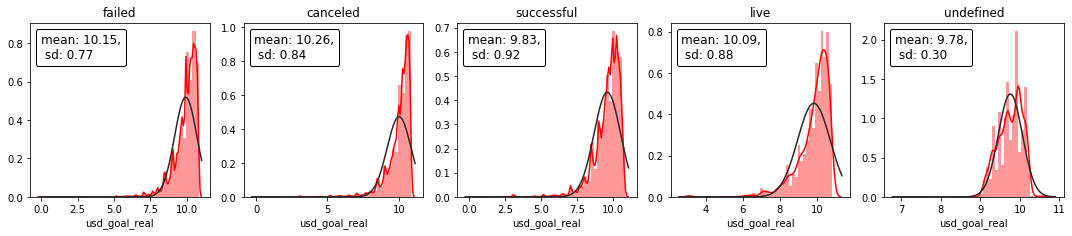

In [41]:
main_st = kick_data.state.unique().tolist()
fkick.create_norm_subplot_log(kick_data,main_st,'state',(15,15),'usd_goal_real',norm)

__Observation #10__: You can see that mean goal amount is highest for cancelled projects compared to successful projets. Furthermore, the standard deviation for canceled projects is higher indicating the wide spread between different goal requests perhaps showing that people are more uncertain as to what goal they should charge.

# 3.5 Top Categories

## 3.5.1

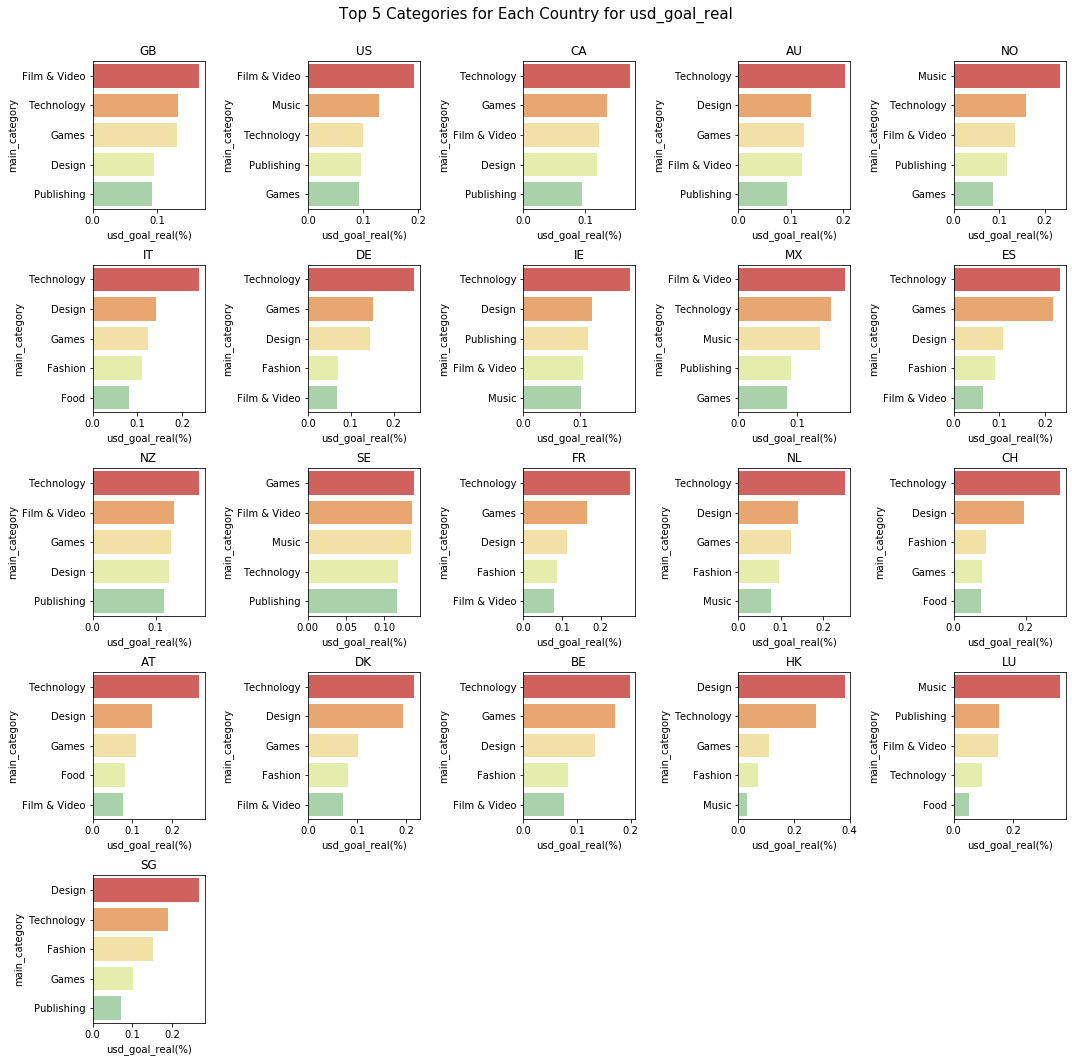

In [49]:
main_co = kick_data.country.unique().tolist()
fkick.create_norm_subplot_cat(kick_data,main_co,'country',(15,15),'usd_goal_real')


__Observation #12__: These charts illustrate percentage of requested goal for the top 5 categories for each country. In fact, Technology is the category that is most likely to show at the top for 11 out of 22 countries (or 55%). There are also slight regional differenes: For example, IT's top category is Art while in CH it is food!

## 3.5.2

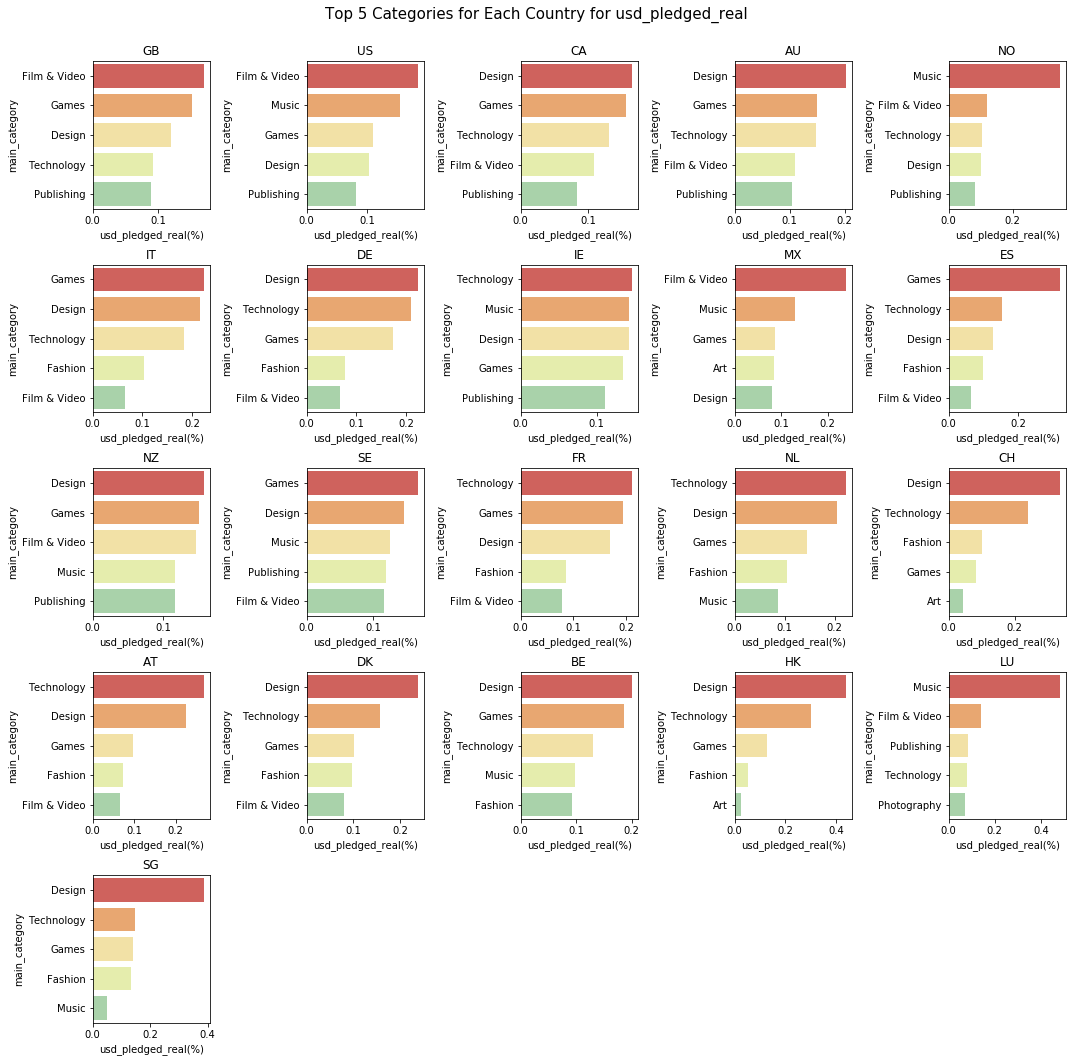

In [51]:
main_co = kick_data.country.unique().tolist()
fkick.create_norm_subplot_cat(kick_data,main_co,'country',(15,15),'usd_pledged_real')

__Observation #13__: This chat shows percentage of monetary pledges for each category in each country. If anything, this chart illustrates that there is some discrepancy between the categories that people request funding for and the categories that actually people pledge to. In fact, design seems like the most popular category across 12 out of 22 countries (54%).Only in BE the top category for pledges (Technology) aligns with the top goal category.

# 3.6 Time Difference Between Launched Date and Deadline Date

In [52]:
#calculate number of projects for each the number of days between launched date and the Deadline Date.
#Convert to percent
# get the top forty launch - deadline percent differerences.
data_kick = kick_data[['launched_deadline_days_diff','usd_goal_real']].groupby(
            ['launched_deadline_days_diff']).agg({'usd_goal_real':
                                                  'count'}).apply(lambda x: x/sum(x)).reset_index().nlargest(40,
                                                                                                             'usd_goal_real')

## 3.6.1

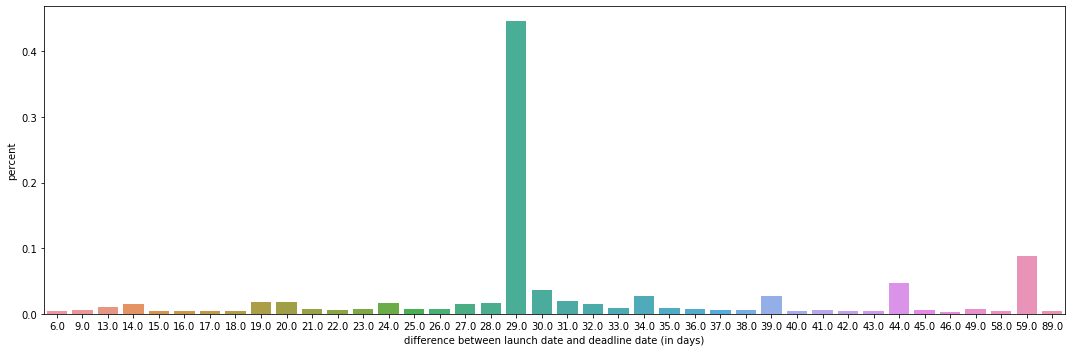

In [53]:
plt.figure(figsize = (15,5))

ax = sns.barplot(x = 'launched_deadline_days_diff', y = 'usd_goal_real',data = data_kick)
ax.set(ylabel= 'percent', xlabel = 'difference between launch date and deadline date (in days)')
plt.tight_layout()

__Observation #14__: This indicates that over 40% of projects tend to have 29 days between when they started and their deadline. This is a bit less than month indicating that for substantial percentage of the projects, the people who started them expect to get funding within a month. 